In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 09:24:10] [setup] RAM Tracking...
[codecarbon INFO @ 09:24:11] [setup] GPU Tracking...
[codecarbon INFO @ 09:24:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:24:11] [setup] CPU Tracking...
[codecarbon WARNING @ 09:24:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:24:13] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 09:24:13] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 09:24:13] >>> Tracker's metadata:
[codecarbon INFO @ 09:24:13]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 09:24:13]   Python version: 3.11.3
[codecarbon INFO @ 09:24:13]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 09:24:13]   Available RAM : 256.000 GB
[codecarbon INFO @ 09:24:13]   CPU count: 24
[codecarbon INFO @ 09:24:13]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# For reproducibility. Same as when the model was trained
HASH_NAME = "18gqn5gdnlbv"

In [5]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [6]:
import pandas as pd
project_name = "rust"

file_name = f"clean_high_vs_med_low_{project_name}_testset.csv"

In [7]:
df = pd.read_csv(file_name)
df

,text,label
0,rustdoc regression in display of macrorules ma...,1
1,clarify which tcpstream methods wont work in n...,0
2,spurious error about sized bound when trait ne...,0
3,rust enums with discriminators greater than ar...,0
4,investigate implementing an localization libra...,1
...,...,...
1565,recent nightly versions break thumb targets he...,1
1566,when encountering for trait object do not also...,0
1567,rustc does display a correct error message on ...,1
1568,rustdoc dos line endings cause extra newlines ...,1


In [8]:
df = df.rename(columns={'text_clean': 'text'})
df = df.dropna()  # This will drop any rows with missing values.
df = df.reset_index(drop=True)
df

,text,label
0,rustdoc regression in display of macrorules ma...,1
1,clarify which tcpstream methods wont work in n...,0
2,spurious error about sized bound when trait ne...,0
3,rust enums with discriminators greater than ar...,0
4,investigate implementing an localization libra...,1
...,...,...
1565,recent nightly versions break thumb targets he...,1
1566,when encountering for trait object do not also...,0
1567,rustc does display a correct error message on ...,1
1568,rustdoc dos line endings cause extra newlines ...,1


In [9]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [10]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

<h2> Testing Inference </h2>


In [11]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [12]:
test_df = df

In [13]:
test_df

,text,label
0,rustdoc regression in display of macrorules ma...,1
1,clarify which tcpstream methods wont work in n...,0
2,spurious error about sized bound when trait ne...,0
3,rust enums with discriminators greater than ar...,0
4,investigate implementing an localization libra...,1
...,...,...
1565,recent nightly versions break thumb targets he...,1
1566,when encountering for trait object do not also...,0
1567,rustc does display a correct error message on ...,1
1568,rustdoc dos line endings cause extra newlines ...,1


In [14]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [15]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [16]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [17]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [18]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'../../01_training/{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 99/99 [00:17<00:00,  5.74it/s]


Fold 1


100%|██████████| 99/99 [00:17<00:00,  5.79it/s]


Fold 2


100%|██████████| 99/99 [00:17<00:00,  5.77it/s]


In [19]:
deberta_predictions


[array([[0.6907965 , 0.3092035 ],
        [0.4499516 , 0.5500484 ],
        [0.39439592, 0.6056041 ],
        ...,
        [0.26303864, 0.73696136],
        [0.6495858 , 0.35041416],
        [0.6975277 , 0.3024723 ]], dtype=float32),
 array([[0.53245556, 0.46754447],
        [0.22467352, 0.7753265 ],
        [0.47762027, 0.5223797 ],
        ...,
        [0.44329566, 0.55670434],
        [0.55670905, 0.44329098],
        [0.7717753 , 0.22822464]], dtype=float32),
 array([[0.17573294, 0.8242671 ],
        [0.61547357, 0.3845265 ],
        [0.51037395, 0.48962608],
        ...,
        [0.2197667 , 0.78023326],
        [0.69857293, 0.301427  ],
        [0.6968893 , 0.30311075]], dtype=float32)]

In [20]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.46632835, 0.5336717 ],
       [0.43003288, 0.5699671 ],
       [0.4607967 , 0.5392033 ],
       ...,
       [0.30870032, 0.6912996 ],
       [0.6349559 , 0.36504403],
       [0.7220641 , 0.2779359 ]], dtype=float32)

In [21]:
len(predictions)

1570

In [22]:
predictions

array([[0.46632835, 0.5336717 ],
       [0.43003288, 0.5699671 ],
       [0.4607967 , 0.5392033 ],
       ...,
       [0.30870032, 0.6912996 ],
       [0.6349559 , 0.36504403],
       [0.7220641 , 0.2779359 ]], dtype=float32)

In [23]:
test_df["prediction_0"] = predictions[:, 0] 

In [24]:
test_df["prediction_1"] = predictions[:, 1] 

In [25]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [26]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
0,rustdoc regression in display of macrorules ma...,1,0.466328,0.533672,0,0,1
1,clarify which tcpstream methods wont work in n...,0,0.430033,0.569967,1,1,0
2,spurious error about sized bound when trait ne...,0,0.460797,0.539203,1,1,0
3,rust enums with discriminators greater than ar...,0,0.355014,0.644986,1,1,1
4,investigate implementing an localization libra...,1,0.702054,0.297946,0,0,0
...,...,...,...,...,...,...,...
1565,recent nightly versions break thumb targets he...,1,0.285283,0.714717,1,1,1
1566,when encountering for trait object do not also...,0,0.301567,0.698433,1,1,1
1567,rustc does display a correct error message on ...,1,0.308700,0.691300,1,1,1
1568,rustdoc dos line endings cause extra newlines ...,1,0.634956,0.365044,0,0,0


In [27]:
len(test_df)

1570

In [28]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [29]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [30]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [31]:
test_df["pred"] = test_df["pred"].astype(int)

In [32]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,rustdoc regression in display of macrorules ma...,1,0.466328,0.533672,0,0,1,prediction_1,1
1,clarify which tcpstream methods wont work in n...,0,0.430033,0.569967,1,1,0,prediction_1,1
2,spurious error about sized bound when trait ne...,0,0.460797,0.539203,1,1,0,prediction_1,1
3,rust enums with discriminators greater than ar...,0,0.355014,0.644986,1,1,1,prediction_1,1
4,investigate implementing an localization libra...,1,0.702054,0.297946,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1565,recent nightly versions break thumb targets he...,1,0.285283,0.714717,1,1,1,prediction_1,1
1566,when encountering for trait object do not also...,0,0.301567,0.698433,1,1,1,prediction_1,1
1567,rustc does display a correct error message on ...,1,0.308700,0.691300,1,1,1,prediction_1,1
1568,rustdoc dos line endings cause extra newlines ...,1,0.634956,0.365044,0,0,0,prediction_0,0


In [33]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[275 510]
 [133 652]]


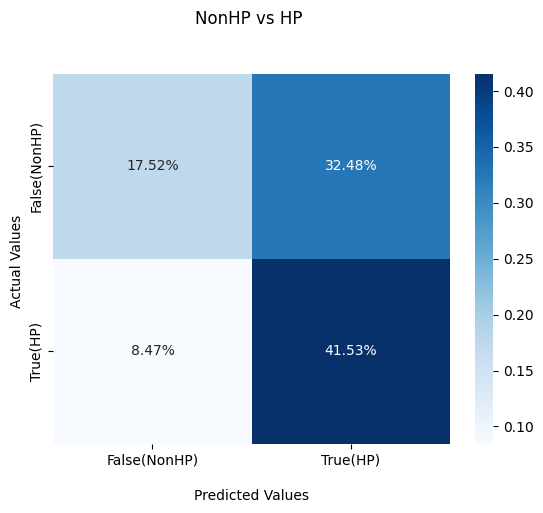

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [35]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.67      0.35      0.46       785
           1       0.56      0.83      0.67       785

    accuracy                           0.59      1570
   macro avg       0.62      0.59      0.57      1570
weighted avg       0.62      0.59      0.57      1570



In [36]:
test_df[["text","label","pred"]].to_csv(f"csv/{project_name}_Test_inference.csv")

In [37]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
0,rustdoc regression in display of macrorules ma...,1,0.466328,0.533672,0,0,1,prediction_1,1
1,clarify which tcpstream methods wont work in n...,0,0.430033,0.569967,1,1,0,prediction_1,1
2,spurious error about sized bound when trait ne...,0,0.460797,0.539203,1,1,0,prediction_1,1
3,rust enums with discriminators greater than ar...,0,0.355014,0.644986,1,1,1,prediction_1,1
4,investigate implementing an localization libra...,1,0.702054,0.297946,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1565,recent nightly versions break thumb targets he...,1,0.285283,0.714717,1,1,1,prediction_1,1
1566,when encountering for trait object do not also...,0,0.301567,0.698433,1,1,1,prediction_1,1
1567,rustc does display a correct error message on ...,1,0.308700,0.691300,1,1,1,prediction_1,1
1568,rustdoc dos line endings cause extra newlines ...,1,0.634956,0.365044,0,0,0,prediction_0,0


In [38]:
tracker.stop()

0.000183831218960499